In [1]:
import os
import time
import joblib
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from model_tf import build_hybrid_model
from hybrid_generator import HybridScalogramPPGGenerator


CONFIGURATION

In [7]:
# Paths for your splits and segments
BASE_DIR = "../data/model_data"
SEGMENTS_DIR = "../data/segments"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

BATCH_SIZE = 32
IMG_SIZE = (128, 128)
EPOCHS = 100

DATA GENERATORS

In [8]:
print("[INFO] Loading data generators...")

# Load training generator (fits scaler)
train_gen = HybridScalogramPPGGenerator(
    image_dir=TRAIN_DIR,
    segment_dir=SEGMENTS_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

# Load validation and test generators (use training scaler)
scaler = train_gen.get_scaler()
val_gen = HybridScalogramPPGGenerator(
    image_dir=VAL_DIR,
    segment_dir=SEGMENTS_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    label_scaler=scaler
)
test_gen = HybridScalogramPPGGenerator(
    image_dir=TEST_DIR,
    segment_dir=SEGMENTS_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False,
    label_scaler=scaler
)

# Save the fitted scaler for later inference
joblib.dump(scaler, "label_scaler.save")
print("[INFO] Label scaler saved to 'label_scaler.save'")

[INFO] Loading data generators...
[INFO] Label scaler saved to 'label_scaler.save'


 MODEL SETUP 

In [9]:
segment_len = train_gen[0][0]['ppg_input'].shape[1]

model = build_hybrid_model(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1), ppg_len=segment_len
    )
model.compile(
    optimizer="adam", 
    loss="mse", 
    metrics=["mae"])
    
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ppg_input           │ (None, 1000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1024, 64)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 32)  │        192 │ ppg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 500, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     49,664 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bp_output (Dense)   │ (None, 2)         │        130 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 159,618 (623.51 KB)

 Trainable params: 159,618 (623.51 KB)

 Non-trainable params: 0 (0.00 B)

CALLBACKS

In [10]:
callbacks = [
    ModelCheckpoint("best_hybrid_model.h5", 
                    monitor="val_mae", 
                    save_best_only=True, 
                    verbose=1),
    
    EarlyStopping(
        monitor="val_mae", 
        patience=10, 
        restore_best_weights=True, 
        verbose=1),
    
    ReduceLROnPlateau(
        monitor="val_mae", 
        factor=0.5, 
        patience=4, 
        verbose=1)
]

TRAINING

In [11]:
print("\nTraining started...")
start_time = time.time()

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

duration = (time.time() - start_time) / 60
print(f"\nTraining completed in {duration:.2f} minutes")


Training started...


c:\Users\shukl\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - loss: 0.7560 - mae: 0.6314
Epoch 1: val_mae improved from inf to 0.44954, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 193s 760ms/step - loss: 0.7555 - mae: 0.6310 - val_loss: 0.5164 - val_mae: 0.4495 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - loss: 0.5854 - mae: 0.4502
Epoch 2: val_mae improved from 0.44954 to 0.41722, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 151s 615ms/step - loss: 0.5851 - mae: 0.4501 - val_loss: 0.4458 - val_mae: 0.4172 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 0.4806 - mae: 0.4097
Epoch 3: val_mae improved from 0.41722 to 0.39337, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 143s 581ms/step - loss: 0.4805 - mae: 0.4097 - val_loss: 0.4260 - val_mae: 0.3934 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.4376 - mae: 0.3922
Epoch 4: val_mae improved from 0.39337 to 0.36671, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 588ms/step - loss: 0.4376 - mae: 0.3921 - val_loss: 0.3861 - val_mae: 0.3667 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 0.4136 - mae: 0.3598
Epoch 5: val_mae improved from 0.36671 to 0.31779, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 144s 585ms/step - loss: 0.4135 - mae: 0.3598 - val_loss: 0.3432 - val_mae: 0.3178 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.3447 - mae: 0.3305
Epoch 6: val_mae did not improve from 0.31779
246/246 ━━━━━━━━━━━━━━━━━━━━ 143s 583ms/step - loss: 0.3449 - mae: 0.3306 - val_loss: 0.3784 - val_mae: 0.3671 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 0.3734 - mae: 0.3359
Epoch 7: val_mae did not improve from 0.31779
246/246 ━━━━━━━━━━━━━━━━━━━━ 153s 623ms/step - loss: 0.3734 - mae: 0.3359 - val_loss: 0.3536 - val_mae: 0.3324 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.3715 - mae: 0.3215
Epoch 8: val_mae improved from 0.31779 to 0.31382, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 143s 581ms/step - loss: 0.3715 - mae: 0.3215 - val_loss: 0.3315 - val_mae: 0.3138 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.3643 - mae: 0.3219
Epoch 9: val_mae did not improve from 0.31382
246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 589ms/step - loss: 0.3643 - mae: 0.3219 - val_loss: 0.3431 - val_mae: 0.3361 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 0.3996 - mae: 0.3174
Epoch 10: val_mae improved from 0.31382 to 0.30368, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 592ms/step - loss: 0.3994 - mae: 0.3174 - val_loss: 0.3242 - val_mae: 0.3037 - learning_rate: 0.0010
Epoch 11/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 0.3355 - mae: 0.3001
Epoch 11: val_mae improved from 0.30368 to 0.29812, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 589ms/step - loss: 0.3356 - mae: 0.3001 - val_loss: 0.3248 - val_mae: 0.2981 - learning_rate: 0.0010
Epoch 12/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.4149 - mae: 0.3147
Epoch 12: val_mae improved from 0.29812 to 0.29068, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 142s 577ms/step - loss: 0.4147 - mae: 0.3146 - val_loss: 0.3114 - val_mae: 0.2907 - learning_rate: 0.0010
Epoch 13/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.3989 - mae: 0.3228
Epoch 13: val_mae improved from 0.29068 to 0.28245, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 587ms/step - loss: 0.3987 - mae: 0.3227 - val_loss: 0.3070 - val_mae: 0.2825 - learning_rate: 0.0010
Epoch 14/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - loss: 0.3114 - mae: 0.2932
Epoch 14: val_mae did not improve from 0.28245
246/246 ━━━━━━━━━━━━━━━━━━━━ 149s 605ms/step - loss: 0.3116 - mae: 0.2933 - val_loss: 0.3629 - val_mae: 0.3546 - learning_rate: 0.0010
Epoch 15/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 0.3709 - mae: 0.3132
Epoch 15: val_mae did not improve from 0.28245
246/246 ━━━━━━━━━━━━━━━━━━━━ 143s 583ms/step - loss: 0.3708 - mae: 0.3132 - val_loss: 0.3335 - val_mae: 0.3215 - learning_rate: 0.0010
Epoch 16/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 0.4006 - mae: 0.3207
Epoch 16: val_mae did not improve from 0.28245
246/246 ━━━━━━━━━━━━━━━━━━━━ 147s 596ms/step - loss: 0.4005 - mae: 0.3207 - val_loss: 0.3158 - val_mae: 0.3008 - learning_rate: 0.0010
Epoch 17/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 237s 964ms/step - loss: 0.3505 - mae: 0.2931 - val_loss: 0.2996 - val_mae: 0.2770 - learning_rate: 5.0000e-04
Epoch 20/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 0.3058 - mae: 0.2826
Epoch 20: val_mae did not improve from 0.27699
246/246 ━━━━━━━━━━━━━━━━━━━━ 148s 600ms/step - loss: 0.3059 - mae: 0.2827 - val_loss: 0.3123 - val_mae: 0.2979 - learning_rate: 5.0000e-04
Epoch 21/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - loss: 0.3380 - mae: 0.2919
Epoch 21: val_mae did not improve from 0.27699
246/246 ━━━━━━━━━━━━━━━━━━━━ 200s 814ms/step - loss: 0.3380 - mae: 0.2918 - val_loss: 0.2998 - val_mae: 0.2876 - learning_rate: 5.0000e-04
Epoch 22/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3282 - mae: 0.2861
Epoch 22: val_mae did not improve from 0.27699
246/246 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - loss: 0.3282 - mae: 0.2861 - val_loss: 0.3298 - val_mae: 0.3116 - learning_rate: 5.0000e-04
Epoch 23/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

246/246 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 0.3545 - mae: 0.2983 - val_loss: 0.2958 - val_mae: 0.2751 - learning_rate: 5.0000e-04
Epoch 24/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - loss: 0.3052 - mae: 0.2746
Epoch 24: val_mae improved from 0.27514 to 0.26990, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 161s 652ms/step - loss: 0.3053 - mae: 0.2746 - val_loss: 0.2942 - val_mae: 0.2699 - learning_rate: 5.0000e-04
Epoch 25/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - loss: 0.3334 - mae: 0.2818
Epoch 25: val_mae did not improve from 0.26990
246/246 ━━━━━━━━━━━━━━━━━━━━ 191s 775ms/step - loss: 0.3334 - mae: 0.2818 - val_loss: 0.3121 - val_mae: 0.2890 - learning_rate: 5.0000e-04
Epoch 26/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3134 - mae: 0.2887
Epoch 26: val_mae did not improve from 0.26990
246/246 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - loss: 0.3135 - mae: 0.2886 - val_loss: 0.3010 - val_mae: 0.2802 - learning_rate: 5.0000e-04
Epoch 27/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2971 - mae: 0.2799
Epoch 27: val_mae did not improve from 0.26990
246/246 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - loss: 0.2973 - mae: 0.2799 - val_loss: 0.3287 - val_mae: 0.3183 - learning_rate: 5.0000e-04
Epoch 28/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss:

246/246 ━━━━━━━━━━━━━━━━━━━━ 184s 744ms/step - loss: 0.3579 - mae: 0.2805 - val_loss: 0.2899 - val_mae: 0.2684 - learning_rate: 2.5000e-04
Epoch 30/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - loss: 0.3601 - mae: 0.2868
Epoch 30: val_mae did not improve from 0.26838
246/246 ━━━━━━━━━━━━━━━━━━━━ 174s 706ms/step - loss: 0.3599 - mae: 0.2867 - val_loss: 0.2943 - val_mae: 0.2694 - learning_rate: 2.5000e-04
Epoch 31/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3611 - mae: 0.2728
Epoch 31: val_mae improved from 0.26838 to 0.26420, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - loss: 0.3609 - mae: 0.2728 - val_loss: 0.2882 - val_mae: 0.2642 - learning_rate: 2.5000e-04
Epoch 32/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2872 - mae: 0.2654
Epoch 32: val_mae improved from 0.26420 to 0.26386, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - loss: 0.2872 - mae: 0.2654 - val_loss: 0.2891 - val_mae: 0.2639 - learning_rate: 2.5000e-04
Epoch 33/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - loss: 0.3194 - mae: 0.2682
Epoch 33: val_mae did not improve from 0.26386
246/246 ━━━━━━━━━━━━━━━━━━━━ 148s 604ms/step - loss: 0.3193 - mae: 0.2682 - val_loss: 0.2893 - val_mae: 0.2674 - learning_rate: 2.5000e-04
Epoch 34/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - loss: 0.2628 - mae: 0.2565
Epoch 34: val_mae did not improve from 0.26386
246/246 ━━━━━━━━━━━━━━━━━━━━ 220s 897ms/step - loss: 0.2630 - mae: 0.2565 - val_loss: 0.2942 - val_mae: 0.2737 - learning_rate: 2.5000e-04
Epoch 35/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 0.2898 - mae: 0.2689
Epoch 35: val_mae did not improve from 0.26386
246/246 ━━━━━━━━━━━━━━━━━━━━ 150s 608ms/step - loss: 0.2899 - mae: 0.2689 - val_loss: 0.2883 - val_mae: 0.2649 - learning_rate: 2.5000e-04
Epoch 36/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/

246/246 ━━━━━━━━━━━━━━━━━━━━ 227s 923ms/step - loss: 0.2667 - mae: 0.2599 - val_loss: 0.2869 - val_mae: 0.2634 - learning_rate: 2.5000e-04
Epoch 37/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 0.2503 - mae: 0.2554
Epoch 37: val_mae did not improve from 0.26340
246/246 ━━━━━━━━━━━━━━━━━━━━ 184s 600ms/step - loss: 0.2505 - mae: 0.2554 - val_loss: 0.2868 - val_mae: 0.2655 - learning_rate: 2.5000e-04
Epoch 38/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - loss: 0.2416 - mae: 0.2516
Epoch 38: val_mae did not improve from 0.26340
246/246 ━━━━━━━━━━━━━━━━━━━━ 224s 912ms/step - loss: 0.2418 - mae: 0.2517 - val_loss: 0.2894 - val_mae: 0.2705 - learning_rate: 2.5000e-04
Epoch 39/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3355 - mae: 0.2822
Epoch 39: val_mae did not improve from 0.26340
246/246 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - loss: 0.3353 - mae: 0.2822 - val_loss: 0.2895 - val_mae: 0.2729 - learning_rate: 2.5000e-04
Epoch 40/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step -

246/246 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - loss: 0.3296 - mae: 0.2604 - val_loss: 0.2817 - val_mae: 0.2573 - learning_rate: 1.2500e-04
Epoch 43/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3264 - mae: 0.2595
Epoch 43: val_mae improved from 0.25727 to 0.25431, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - loss: 0.3262 - mae: 0.2595 - val_loss: 0.2805 - val_mae: 0.2543 - learning_rate: 1.2500e-04
Epoch 44/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2400 - mae: 0.2470
Epoch 44: val_mae did not improve from 0.25431
246/246 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - loss: 0.2402 - mae: 0.2471 - val_loss: 0.2817 - val_mae: 0.2588 - learning_rate: 1.2500e-04
Epoch 45/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2500 - mae: 0.2467
Epoch 45: val_mae did not improve from 0.25431
246/246 ━━━━━━━━━━━━━━━━━━━━ 2019s 8s/step - loss: 0.2501 - mae: 0.2467 - val_loss: 0.2816 - val_mae: 0.2657 - learning_rate: 1.2500e-04
Epoch 46/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 0.3335 - mae: 0.2655
Epoch 46: val_mae did not improve from 0.25431
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 593ms/step - loss: 0.3332 - mae: 0.2654 - val_loss: 0.2815 - val_mae: 0.2590 - learning_rate: 1.2500e-04
Epoch 47/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss

246/246 ━━━━━━━━━━━━━━━━━━━━ 148s 602ms/step - loss: 0.2547 - mae: 0.2519 - val_loss: 0.2773 - val_mae: 0.2533 - learning_rate: 6.2500e-05
Epoch 50/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 0.2371 - mae: 0.2453
Epoch 50: val_mae improved from 0.25333 to 0.25324, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 588ms/step - loss: 0.2372 - mae: 0.2454 - val_loss: 0.2759 - val_mae: 0.2532 - learning_rate: 6.2500e-05
Epoch 51/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - loss: 0.2545 - mae: 0.2460
Epoch 51: val_mae did not improve from 0.25324
246/246 ━━━━━━━━━━━━━━━━━━━━ 148s 601ms/step - loss: 0.2545 - mae: 0.2460 - val_loss: 0.2775 - val_mae: 0.2548 - learning_rate: 6.2500e-05
Epoch 52/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 0.2695 - mae: 0.2462
Epoch 52: val_mae did not improve from 0.25324
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 594ms/step - loss: 0.2695 - mae: 0.2462 - val_loss: 0.2764 - val_mae: 0.2543 - learning_rate: 6.2500e-05
Epoch 53/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 0.3029 - mae: 0.2508
Epoch 53: val_mae improved from 0.25324 to 0.25314, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 147s 598ms/step - loss: 0.3027 - mae: 0.2508 - val_loss: 0.2769 - val_mae: 0.2531 - learning_rate: 6.2500e-05
Epoch 54/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - loss: 0.3453 - mae: 0.2524
Epoch 54: val_mae improved from 0.25314 to 0.25293, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 204s 606ms/step - loss: 0.3450 - mae: 0.2524 - val_loss: 0.2771 - val_mae: 0.2529 - learning_rate: 6.2500e-05
Epoch 55/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 0.2783 - mae: 0.2482
Epoch 55: val_mae did not improve from 0.25293
246/246 ━━━━━━━━━━━━━━━━━━━━ 147s 599ms/step - loss: 0.2782 - mae: 0.2482 - val_loss: 0.2776 - val_mae: 0.2558 - learning_rate: 6.2500e-05
Epoch 56/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.2594 - mae: 0.2428
Epoch 56: val_mae improved from 0.25293 to 0.25094, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 591ms/step - loss: 0.2594 - mae: 0.2428 - val_loss: 0.2765 - val_mae: 0.2509 - learning_rate: 6.2500e-05
Epoch 57/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - loss: 0.2417 - mae: 0.2435
Epoch 57: val_mae did not improve from 0.25094
246/246 ━━━━━━━━━━━━━━━━━━━━ 149s 605ms/step - loss: 0.2418 - mae: 0.2435 - val_loss: 0.2784 - val_mae: 0.2558 - learning_rate: 6.2500e-05
Epoch 58/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 0.2403 - mae: 0.2478
Epoch 58: val_mae did not improve from 0.25094
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 592ms/step - loss: 0.2404 - mae: 0.2478 - val_loss: 0.2766 - val_mae: 0.2522 - learning_rate: 6.2500e-05
Epoch 59/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 0.2239 - mae: 0.2417
Epoch 59: val_mae did not improve from 0.25094
246/246 ━━━━━━━━━━━━━━━━━━━━ 148s 600ms/step - loss: 0.2241 - mae: 0.2418 - val_loss: 0.2760 - val_mae: 0.2533 - learning_rate: 6.2500e-05
Epoch 60/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 560


Epoch 60: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 594ms/step - loss: 0.2901 - mae: 0.2520 - val_loss: 0.2770 - val_mae: 0.2509 - learning_rate: 6.2500e-05
Epoch 61/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.2476 - mae: 0.2402
Epoch 61: val_mae improved from 0.25090 to 0.24907, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 588ms/step - loss: 0.2476 - mae: 0.2402 - val_loss: 0.2740 - val_mae: 0.2491 - learning_rate: 3.1250e-05
Epoch 62/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.2436 - mae: 0.2434
Epoch 62: val_mae did not improve from 0.24907
246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 590ms/step - loss: 0.2437 - mae: 0.2434 - val_loss: 0.2749 - val_mae: 0.2520 - learning_rate: 3.1250e-05
Epoch 63/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 0.2260 - mae: 0.2405
Epoch 63: val_mae did not improve from 0.24907
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 594ms/step - loss: 0.2261 - mae: 0.2406 - val_loss: 0.2753 - val_mae: 0.2522 - learning_rate: 3.1250e-05
Epoch 64/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 0.2266 - mae: 0.2376
Epoch 64: val_mae did not improve from 0.24907
246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 591ms/step - loss: 0.2267 - mae: 0.2376 - val_loss: 0.2745 - val_mae: 0.2493 - learning_rate: 3.1250e-05
Epoch 65/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 556

246/246 ━━━━━━━━━━━━━━━━━━━━ 145s 590ms/step - loss: 0.2848 - mae: 0.2475 - val_loss: 0.2735 - val_mae: 0.2485 - learning_rate: 1.5625e-05
Epoch 67/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 0.2770 - mae: 0.2397
Epoch 67: val_mae improved from 0.24846 to 0.24811, saving model to best_hybrid_model.h5


246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 592ms/step - loss: 0.2769 - mae: 0.2397 - val_loss: 0.2730 - val_mae: 0.2481 - learning_rate: 1.5625e-05
Epoch 68/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 0.3240 - mae: 0.2492
Epoch 68: val_mae did not improve from 0.24811
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 595ms/step - loss: 0.3237 - mae: 0.2492 - val_loss: 0.2731 - val_mae: 0.2497 - learning_rate: 1.5625e-05
Epoch 69/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - loss: 0.2221 - mae: 0.2361
Epoch 69: val_mae did not improve from 0.24811
246/246 ━━━━━━━━━━━━━━━━━━━━ 208s 620ms/step - loss: 0.2222 - mae: 0.2362 - val_loss: 0.2731 - val_mae: 0.2484 - learning_rate: 1.5625e-05
Epoch 70/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.2480 - mae: 0.2379
Epoch 70: val_mae did not improve from 0.24811
246/246 ━━━━━━━━━━━━━━━━━━━━ 155s 631ms/step - loss: 0.2480 - mae: 0.2380 - val_loss: 0.2729 - val_mae: 0.2482 - learning_rate: 1.5625e-05
Epoch 71/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 590

246/246 ━━━━━━━━━━━━━━━━━━━━ 155s 630ms/step - loss: 0.2258 - mae: 0.2380 - val_loss: 0.2725 - val_mae: 0.2476 - learning_rate: 7.8125e-06
Epoch 73/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - loss: 0.2680 - mae: 0.2413
Epoch 73: val_mae did not improve from 0.24764
246/246 ━━━━━━━━━━━━━━━━━━━━ 154s 625ms/step - loss: 0.2679 - mae: 0.2413 - val_loss: 0.2725 - val_mae: 0.2477 - learning_rate: 7.8125e-06
Epoch 74/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.2663 - mae: 0.2425
Epoch 74: val_mae did not improve from 0.24764
246/246 ━━━━━━━━━━━━━━━━━━━━ 156s 632ms/step - loss: 0.2663 - mae: 0.2425 - val_loss: 0.2725 - val_mae: 0.2484 - learning_rate: 7.8125e-06
Epoch 75/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.2177 - mae: 0.2345
Epoch 75: val_mae did not improve from 0.24764
246/246 ━━━━━━━━━━━━━━━━━━━━ 157s 638ms/step - loss: 0.2178 - mae: 0.2345 - val_loss: 0.2726 - val_mae: 0.2496 - learning_rate: 7.8125e-06
Epoch 76/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 609

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from tensorflow.keras.models import load_model

# --- Define paths ---
test_dir = "../data/model_data/test"
segments_dir = "../data/segments"
scaler = joblib.load("label_scaler.save")
model = load_model("best_hybrid_model.h5", compile=False)

# --- Recreate label_map from filenames ---
def build_label_map(image_folder):
    label_map = {}
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
    for fname in image_files:
        if "_scalogram_" in fname:
            parts = fname.split("_scalogram_")
            if len(parts) == 2 and parts[1].endswith(".png"):
                base = parts[0]
                try:
                    idx = int(parts[1].replace(".png", ""))
                    label_map[fname] = (base, idx)
                except:
                    continue
    return label_map

label_map = build_label_map(test_dir)

# --- Initialize arrays ---
X_img_test = []
X_ppg_test = []
valid_y = []

# --- Load scalogram and corresponding PPG segments ---
for fname in sorted(os.listdir(test_dir)):
    if not fname.endswith(".png"):
        continue
    try:
        # Load scalogram
        img_path = os.path.join(test_dir, fname)
        img = load_img(img_path, color_mode="grayscale", target_size=(128, 128))
        img = img_to_array(img).astype("float32") / 255.0
        X_img_test.append(img)

        # Extract base file and index using label_map
        if fname not in label_map:
            print(f"Skipping {fname}: not found in label_map")
            continue
        base, idx = label_map[fname]
        ppg_path = os.path.join(segments_dir, f"{base}_segments.npy")
        label_path = os.path.join(segments_dir, f"{base}_labels.npy")

        if not os.path.exists(ppg_path) or not os.path.exists(label_path):
            print(f"Skipping {fname}: segment or label file not found")
            continue

        segments = np.load(ppg_path)
        labels = np.load(label_path)

        if idx >= len(segments) or idx >= len(labels):
            print(f"Skipping {fname}: index out of bounds in segment or label")
            continue

        X_ppg_test.append(segments[idx][:, np.newaxis])
        valid_y.append(labels[idx])

    except Exception as e:
        print(f"Skipping {fname}: {e}")

# --- Convert to arrays ---
X_img_test = np.array(X_img_test)
X_ppg_test = np.array(X_ppg_test)
y_test = np.array(valid_y)

# --- Scale labels ---
y_test_scaled = scaler.transform(y_test)

# --- Predict ---
y_pred_scaled = model.predict({"image_input": X_img_test, "ppg_input": X_ppg_test}, verbose=1)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test = scaler.inverse_transform(y_test_scaled)

# --- Metrics ---
sbp_mae = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
dbp_mae = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
sbp_rmse = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
dbp_rmse = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
sbp_r2 = r2_score(y_test[:, 0], y_pred[:, 0])
dbp_r2 = r2_score(y_test[:, 1], y_pred[:, 1])

# --- Print Results ---
print(f"[SBP] MAE : {sbp_mae:.2f}")
print(f"[SBP] RMSE: {sbp_rmse:.2f}")
print(f"[SBP] R2  : {sbp_r2:.3f}")
print(f"[DBP] MAE : {dbp_mae:.2f}")
print(f"[DBP] RMSE: {dbp_rmse:.2f}")
print(f"[DBP] R2  : {dbp_r2:.3f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step
[SBP] MAE : 6.05
[SBP] RMSE: 10.49
[SBP] R2  : 0.800
[DBP] MAE : 3.69
[DBP] RMSE: 9.56
[DBP] R2  : 0.603


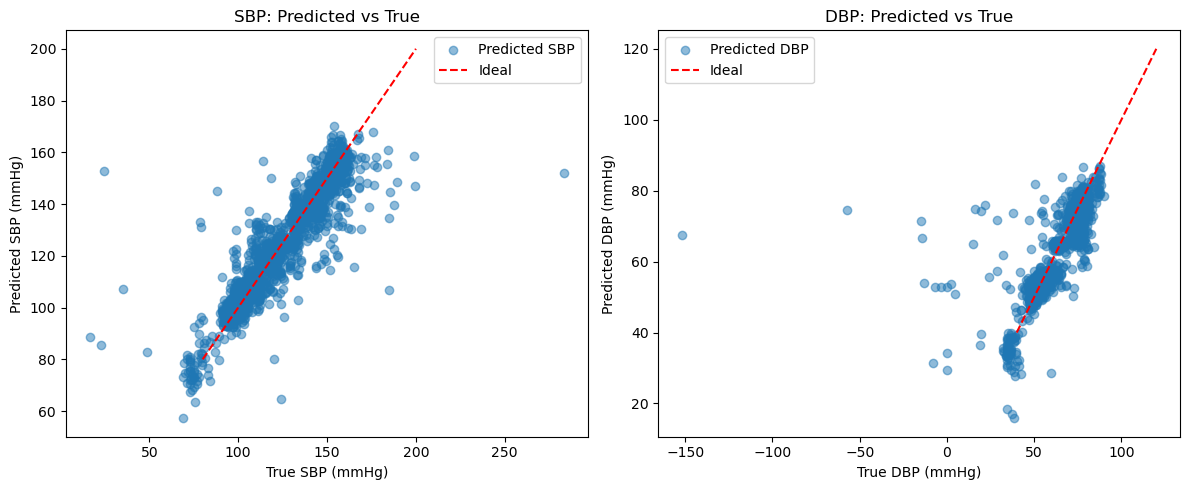

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- SBP Plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5, label="Predicted SBP")
plt.plot([80, 200], [80, 200], 'r--', label="Ideal")
plt.xlabel("True SBP (mmHg)")
plt.ylabel("Predicted SBP (mmHg)")
plt.title("SBP: Predicted vs True")
plt.legend()

# --- DBP Plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5, label="Predicted DBP")
plt.plot([40, 120], [40, 120], 'r--', label="Ideal")
plt.xlabel("True DBP (mmHg)")
plt.ylabel("Predicted DBP (mmHg)")
plt.title("DBP: Predicted vs True")
plt.legend()

plt.tight_layout()
plt.show()
